In [1]:
from os import listdir, mkdir
from os.path import isdir, isfile
from scipy.stats.stats import spearmanr, pearsonr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BufferedReader

rcParams = {'font.size': 30 , 'font.weight': 'normal', 'font.family': 'sans-serif',
            'axes.unicode_minus':False, 'axes.labelweight':'normal'}
plt.rcParams.update(rcParams)

In [21]:
counts_path = '../../../../Mount-2/Datasets/Tara_Oceans_Polar/Reads_410_BP/Counts.dict'
scrapt_path = '../../../../Mount-2/Experiments/Tara_Oceans_Polar/Adaptive_With_Modeshifting/sim_0.98/alpha_0.05/'
dada2_centroid = '../../../../Mount-2/Experiments/Tara_Oceans_Polar/DADA2_Benchmarks/dada2_centroids.fna' 
dada2_results = '../../../../Mount-2/Experiments/Tara_Oceans_Polar/DADA2_Benchmarks/tara_ocean_larger_dts_dada2_centroids_counts.txt'
dada2_scrapt = '../../../../Mount-2/Experiments/Tara_Oceans_Polar/DADA2_Benchmarks/SCRAPT_DADA2/sim_0.98_alpha_0.05_0.99'

In [16]:
counts_path = '/Users/harihara/Mount-2/Datasets/Earth_Microbiome/Counts.soil.dict'
scrapt_path = '/Users/harihara/Mount-2/Experiments/Spatil_Soil/Adaptive_With_Modeshifting/sim_0.97/alpha_0.05/'
dada2_centroid = '/Users/harihara/Mount-2/Experiments/Spatil_Soil/Dada2Benchmark_8/scrapt_vs_dada2/dada2_soil_join.fna' 
dada2_results = '/Users/harihara/Mount-2/Experiments/Spatil_Soil/Dada2Benchmark_8/soil_joining'
dada2_scrapt = '/Users/harihara/Mount-2/Experiments/Spatil_Soil/Dada2Benchmark_8/DADA2_SCRAPT/sim_0.97_alpha_0.05_0.98'

In [29]:
counts_path = '/Users/harihara/Mount-2/Datasets/Lupus-Microbiome-Published/Counts.dict'
scrapt_path = '/Users/harihara/Mount-2/Experiments/Lupus_Microbiome_MT/Adaptive_With_Modeshifting/sim_0.98/alpha_0.1/'
dada2_centroid = '/Users/harihara/Mount-2/Experiments/Lupus-Microbiome-Published/DADA2_Benchmarks/by_sample_dada2_vs_scrapt/dada2vsScrapt_ap/by_sample_luo.fna'
dada2_results = '/Users/harihara/Mount-2/Experiments/Lupus-Microbiome-Published/DADA2_Benchmarks/by_sample_dada2_vs_scrapt/dada2vsScrapt_ap/luo_by_sample.csv'
dada2_scrapt = '/Users/harihara/Mount-2/Experiments/Lupus-Microbiome-Published/DADA2_Benchmarks/DADA2_SCRAPT/sim_0.98_alpha_0.1_0.99'

In [3]:
with open(counts_path,'r') as f:
    S = f.read().replace('\n','')
counts_dict = eval(S)

In [18]:
def Parse_DNACLUST(filepath, cluster):
    op = {}
    counts = []
    centroids = []
    lines = open(filepath,'r').readlines()
    err_ctr = 0
    with open(filepath) as fileobject:
        for l in fileobject:
            seqs = l.rstrip().split()
            c = seqs[0]
            for s in list(set(seqs)):
                try:
                    x = op[s]
                    err_ctr += 1
                    continue
                except KeyError:
                    pass
                op[s] = cluster
                centroids.append(c)
                try:
                    counts.append(int(counts_dict[s]['Counts']))
                except KeyError:
                    counts.append(1)
            cluster += 1
    df_scrapt_clusters = pd.DataFrame(data = {'Sequence_ID':list(op.keys()), 
                                              'Cluster_ID':list(op.values()),
                                              'Centroid':centroids,
                                              'SCRAPT_Counts':counts})
    return df_scrapt_clusters, cluster

def Load_SCRAPT_Results(data_path):
    cluster = 0
    df_scrapt = pd.DataFrame()
    for s in sorted(listdir(data_path)):
        if s.startswith('Iteration'):
            print(s)
            filepath = data_path+s+'/dnaclust_mode_bait'
            df_scrapt_iter, cluster = Parse_DNACLUST(filepath, cluster)
            df_scrapt = df_scrapt.append(df_scrapt_iter, ignore_index = True)
    print(len(df_scrapt))
    df_scrapt = df_scrapt.groupby('Centroid').aggregate({'Cluster_ID':'count','SCRAPT_Counts':sum})
    df_scrapt = df_scrapt.reset_index().rename(columns = {'Centroid':'SCRAPT_Centroid'})
    df_scrapt = df_scrapt.set_index('SCRAPT_Centroid')
    return df_scrapt

def Load_DADA2_Results(seq_path, results_path):
    buf = []
    op = []
    
    with open(seq_path) as fileobject:
        for l in fileobject:
            buf.append(l)
    for i in range(0, len(buf), 2):
        seq_id = buf[i].replace("\n","").replace(">","")
        seq = buf[i+1].replace("\n","")
        op.append({'DADA2_Centroid':seq_id, 'Seq':seq})
    df_centroids = pd.DataFrame(op)
    df_centroids = df_centroids.set_index('Seq')
    df_cluster_counts = pd.read_csv(results_path, sep = ";", skiprows=1, names=['Seq', 'DADA2_Counts'], 
                                    index_col = 'Seq')
    
    df_cluster_counts = df_cluster_counts.join(df_centroids)
    return df_cluster_counts.set_index('DADA2_Centroid')[['DADA2_Counts']]

def Load_DADA2_Map(dada2_scrapt, dada2_seed):
    lines = open(dada2_scrapt).readlines()
    op = []
    for l in lines:
        seqs = l.rstrip().split()
        d = {}
        centroid = seqs[0]
        for s in seqs[1:]:
            if dada2_seed:
                op.append({'DADA2_Centroid':centroid, 'SCRAPT_Centroid':s})
            else:
                op.append({'DADA2_Centroid':s, 'SCRAPT_Centroid':centroid})
    df_map = pd.DataFrame(op)
    return df_map

In [30]:
df_SCRAPT = Load_SCRAPT_Results(scrapt_path)

Iteration_0
Iteration_1
Iteration_10
Iteration_11
Iteration_12
Iteration_13
Iteration_14
Iteration_15
Iteration_16
Iteration_17
Iteration_18
Iteration_19
Iteration_2
Iteration_20
Iteration_21
Iteration_22
Iteration_23
Iteration_24
Iteration_25
Iteration_26
Iteration_27
Iteration_28
Iteration_29
Iteration_3
Iteration_30
Iteration_31
Iteration_32
Iteration_33
Iteration_34
Iteration_35
Iteration_36
Iteration_37
Iteration_38
Iteration_39
Iteration_4
Iteration_40
Iteration_41
Iteration_42
Iteration_43
Iteration_44
Iteration_45
Iteration_46
Iteration_47
Iteration_48
Iteration_49
Iteration_5
Iteration_6
Iteration_7
Iteration_8
Iteration_9
903617


In [31]:
df_DADA2 = Load_DADA2_Results(dada2_centroid, dada2_results)

In [35]:
df_map = Load_DADA2_Map(dada2_scrapt, False)
df_DADA2_Map = pd.merge(df_DADA2, df_map, on = 'DADA2_Centroid', how = 'outer')
counter = len(df_DADA2_Map[df_DADA2_Map['SCRAPT_Centroid'].isna()])
df_DADA2_Map.loc[df_DADA2_Map['SCRAPT_Centroid'].isna(), 'SCRAPT_Centroid'] = np.arange(-1*counter, 0)
df_DADA2_Map = df_DADA2_Map.groupby('SCRAPT_Centroid').sum()[['DADA2_Counts']]
df_DADA2_Map = df_DADA2_Map.join(df_SCRAPT, how = 'outer')
df_DADA2_Map = df_DADA2_Map.fillna(1)

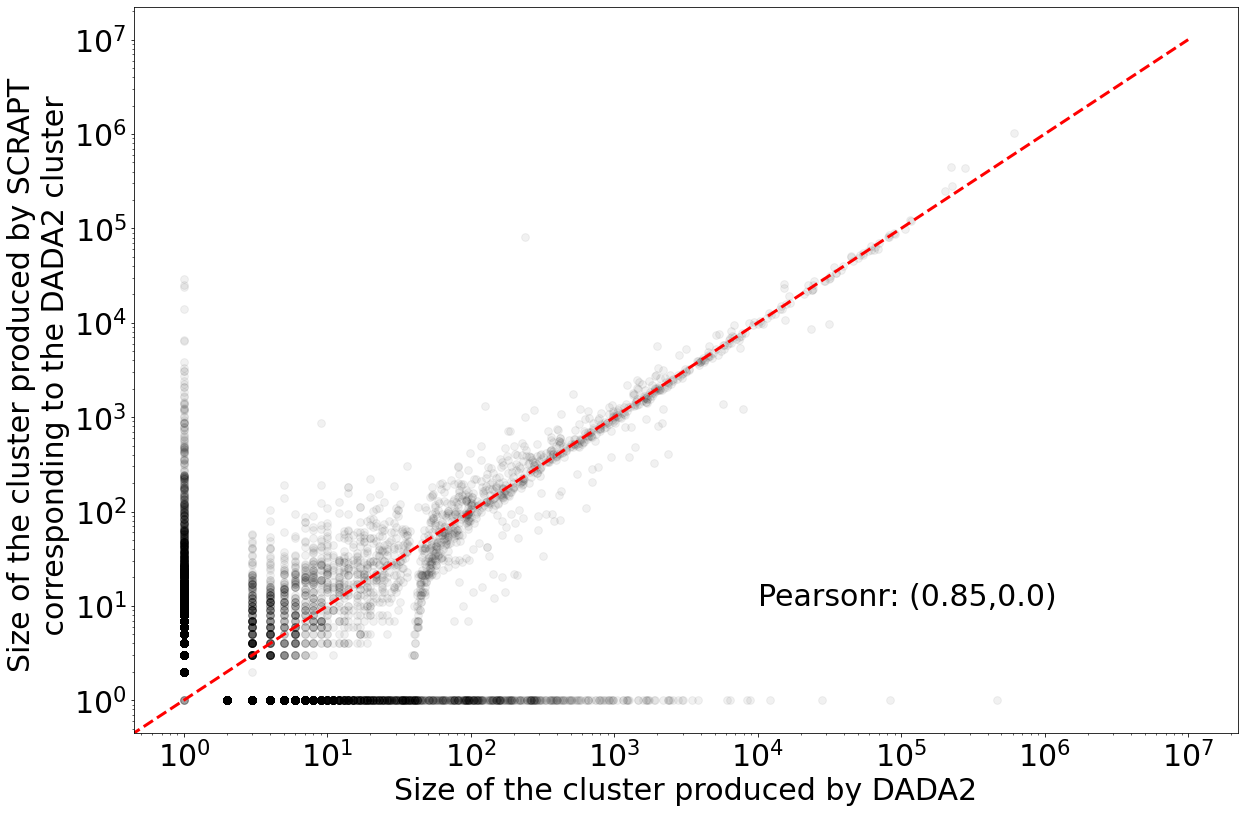

In [36]:
plt.rcParams.update(rcParams)
fig, ax = plt.subplots(1,1,figsize = (18,12))
df_DADA2_Map.plot.scatter('DADA2_Counts','SCRAPT_Counts', s = 60, ax = ax, color = 'black', alpha = 0.055)
ax.plot([0,10000000], [0,10000000], color = 'red', linestyle = '--', linewidth = 3.0)
ax.set_xlabel('Size of the cluster produced by DADA2')
ax.set_ylabel('Size of the cluster produced by SCRAPT \n corresponding to the DADA2 cluster')
ax.set_xscale('log')
ax.set_yscale('log')
fig.tight_layout()

pearson_r = round(pearsonr(df_DADA2_Map['DADA2_Counts'], df_DADA2_Map['SCRAPT_Counts'])[0], 2)
pearson_p = round(pearsonr(df_DADA2_Map['DADA2_Counts'], df_DADA2_Map['SCRAPT_Counts'])[1])

spearman_r = round(spearmanr(df_DADA2_Map['DADA2_Counts'], df_DADA2_Map['SCRAPT_Counts'])[0], 2)

ax.text(10000, 10, 'Pearsonr: ('+str(pearson_r)+','+str(pearson_p)+')')

plots_dir = '/Users/harihara/Research-Activities/Plots/Iterative_Clustering/Lupus-Microbiome-MT/'
fig.savefig(plots_dir+'Comparing_DADA2_SCRAPT_0.98_Sum.pdf')
fig.savefig(plots_dir+'Comparing_DADA2_SCRAPT_0.98_Sum.png', dpi = 200)
